# Train a Neural Network for Regression

This practical session will cover the building and training of a neural network with [pytorch](https://docs.pytorch.org/tutorials/intro.html) and with [optuna](https://optuna.readthedocs.io/en/stable/index.html).

We want to work on the regression problem with the "HB energy" data to be able to compare the training process and prediction results.

## Data preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

### Load and inspect data

In [2]:
df = pd.read_csv('data/HB_data.csv', sep=',')
display(df.tail(10))
print(df.info())
print('Missing values:', df.isnull().sum().sum())

,energy,bo-acc,bo-donor,q-acc,q-donor,q-hatom,dist-dh,dist-ah,atomtype-acc,atomtype-don
1628,-16.2384,0.0392,0.9798,-0.171865,-0.027486,0.064607,1.008853,2.491147,O,N
1629,-24.9033,0.1690,1.0993,-0.191174,-0.183888,0.029836,0.973936,1.726064,O,O
1630,-26.4679,0.1395,1.1069,-0.198331,-0.180041,0.039182,0.973682,1.826318,O,O
1631,-26.5155,0.1166,1.1137,-0.203101,-0.176368,0.045722,0.973062,1.926938,O,O
1632,-25.5760,0.0982,1.1196,-0.206464,-0.172994,0.050628,0.972319,2.027681,O,O
1633,-24.1264,0.0832,1.1248,-0.208975,-0.169954,0.054530,0.971506,2.128494,O,O
1634,-22.4911,0.0707,1.1291,-0.210940,-0.167299,0.057801,0.970708,2.229292,O,O
1635,-20.7796,0.0599,1.1329,-0.212591,-0.164774,0.060660,0.969920,2.330080,O,O
1636,-18.6559,0.0506,1.1361,-0.213856,-0.162590,0.063149,0.969171,2.430829,O,O
1637,-17.0634,0.0433,1.1385,-0.214541,-0.160926,0.065275,0.968484,2.531516,O,O


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1638 entries, 0 to 1637
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   energy        1638 non-null   float64
 1   bo-acc        1638 non-null   float64
 2   bo-donor      1638 non-null   float64
 3   q-acc         1638 non-null   float64
 4   q-donor       1638 non-null   float64
 5   q-hatom       1638 non-null   float64
 6   dist-dh       1638 non-null   float64
 7   dist-ah       1638 non-null   float64
 8   atomtype-acc  1638 non-null   object 
 9   atomtype-don  1638 non-null   object 
dtypes: float64(8), object(2)
memory usage: 128.1+ KB
None
Missing values: 0


### Prepare train and test data

We will apply nearly the same preprocessing steps we've alreday seen in the regression session in day 1.

In [3]:
# Separate features and target
target_col = "energy"

X = df.drop(columns=[target_col])
# We need y to be a 2-D array (n_samples x n_features)
y = df[target_col].to_numpy().reshape(-1, 1)

In [4]:
# Get train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Preprocess and transform features
numeric_features = X.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

# Define scaling and encoding for X
x_preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ],
    remainder="drop",
)
# Define scaling for y
y_scaler = StandardScaler()

# Fit scaling for X on train data only, apply (transform) scaling to both train and test
X_train_t = x_preprocessor.fit_transform(X_train)
X_test_t = x_preprocessor.transform(X_test)

# Fit scaling for y on train data only, apply (transform) scaling to both train and test
y_train_t = y_scaler.fit_transform(y_train)
y_test_t = y_scaler.transform(y_test)

# Get transformed feature names (handy for inspection)
feat_names = x_preprocessor.get_feature_names_out()
    
# Inspect transformed data
print("X_train: ", X_train_t.shape)
print("X_test:  ", X_test_t.shape)
print("y_train: ", y_train_t.shape)
print("y_test:  ", y_test_t.shape)
display(pd.DataFrame(X_train_t, columns=feat_names).head(5))

X_train:  (1310, 16)
X_test:   (328, 16)
y_train:  (1310, 1)
y_test:   (328, 1)


,num__bo-acc,num__bo-donor,num__q-acc,num__q-donor,num__q-hatom,num__dist-dh,num__dist-ah,cat__atomtype-acc_Cl,cat__atomtype-acc_F,cat__atomtype-acc_N,cat__atomtype-acc_O,cat__atomtype-acc_S,cat__atomtype-don_F,cat__atomtype-don_N,cat__atomtype-don_O,cat__atomtype-don_S
0,1.528941,1.085590,1.302776,-1.044430,-1.755071,-0.695289,-0.405888,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.440623,-1.342533,-0.432635,1.960155,1.517928,0.116373,-1.061508,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.949121,0.945702,1.456768,-1.074853,-1.244247,-0.649960,-0.078786,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.517228,0.568121,-0.897550,-1.268309,0.114001,-0.418482,-0.856478,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-1.014869,0.803541,-0.243681,-0.295638,0.791833,-0.634377,0.604197,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Build and train model with PyTorch

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from tqdm.auto import tqdm

import optuna
import logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [7]:
# Check if GPU is available to be used with pytorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Define objects for model and training process

In [8]:
# Define the model with a parameterizable architecture
class MLPRegressorTorch(nn.Module):
    def __init__(self, in_dim, hidden=(64, 32), dropout=0.1):
        super().__init__()
        layers = []
        prev = in_dim
        for h in hidden:
            layers += [
                nn.Linear(prev, h), # fully connected layer from prev inputs to h outputs
                nn.ReLU(), # non-linear activation with rectified linear unit
                nn.Dropout(dropout) # regularization: randomly zeroes activations with probability dropout
                ]
            prev = h
        layers += [nn.Linear(prev, 1)] # Regression output with a single neuron for continuous value
        self.net = nn.Sequential(*layers)

    def forward(self, x): 
        return self.net(x)

In [9]:
# Define function to create pytorch data loaders
def make_loaders(X_train_t, y_train_t, X_test_t, y_test_t, batch_size):
    # Convert data (numpy arrays) to torch tensors
    X_train_ts = torch.tensor(X_train_t, dtype=torch.float32)
    y_train_ts = torch.tensor(y_train_t, dtype=torch.float32)
    X_test_ts = torch.tensor(X_test_t, dtype=torch.float32)
    y_test_ts = torch.tensor(y_test_t, dtype=torch.float32)
    # Build torch dataset and dataloader for batches
    train_loader = DataLoader(TensorDataset(X_train_ts, y_train_ts), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_ts, y_test_ts), batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [10]:
# Define function for training loop with hyperparameter configuration
def objective(trial):
    # Define hyperparameter search space for optuna
    hidden_layers_list = [(256, 128, 64), (128, 64), (64, 32), (64,)]
    idx = trial.suggest_int("hidden_layers_idx", 0, len(hidden_layers_list)-1)
    hidden_layers = hidden_layers_list[idx]
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    lr = trial.suggest_float("lr", 5e-4, 3e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128, 256])
    epochs = 50

    # Get data loaders for train and test data
    train_loader, test_loader = make_loaders(X_train_t, y_train_t, X_test_t, y_test_t, batch_size)

    # Initialise model and put to device (CPU or GPU)
    model = MLPRegressorTorch(
        in_dim=X_train_t.shape[1],
        hidden=hidden_layers,
        dropout=dropout
        ).to(device)
    # Define optimizer: Adam with weight decay (L2 regularization)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # Define loss function: Mean Squared Error
    loss_fn = nn.MSELoss()
    
    # Run epochs for training with validation at the end of each epoch
    for epoch in tqdm(range(epochs), desc="Epochs", leave=False):
        # Train with model updates
        model.train()
        train_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x_batch.size(0)
        train_loss /= len(train_loader.dataset)

        # Validate for test data without model updates
        model.eval()
        val_loss = 0.0
        preds, trues = [], []
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch = x_batch.to(device)
                pred = model(x_batch)
                val_loss += loss_fn(pred, y_batch.to(device)).item() * x_batch.size(0)
                preds.append(pred.cpu().numpy())
                trues.append(y_batch.cpu().numpy())
        val_loss /= len(test_loader.dataset)

        # Get RMSE in original units (invert scaling for y)
        y_pred = y_scaler.inverse_transform(np.vstack(preds))
        y_true = y_scaler.inverse_transform(np.vstack(trues))
        val_rmse = math.sqrt(float(np.mean((y_pred - y_true) ** 2)))

        # Report to Optuna
        trial.report(val_rmse, step=epoch)
        trial.set_user_attr(f"train_loss_epoch_{epoch}", float(train_loss))
        trial.set_user_attr(f"val_loss_epoch_{epoch}", float(val_loss))
        trial.set_user_attr(f"val_rmse_epoch_{epoch}", val_rmse)
        if trial.should_prune():
            raise optuna.TrialPruned()
        
    return val_rmse   

### Run training with hyperparameter optimization

In [ ]:
# Run model training and hyperparameter optimization with optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20, timeout=600)

## Evaluate model

In [12]:
best_trial = study.best_trial
display("Params:", best_trial.params)
print("Best RMSE:", best_trial.value)

'Params:'

{'hidden_layers_idx': 0,
 'dropout': 0.007087859540424846,
 'lr': 0.0010776365403513469,
 'weight_decay': 2.8400326138316148e-06,
 'batch_size': 16}

Best RMSE: 1.7798393419177838


In [13]:
# Get all trials as DataFrame
df_all = study.trials_dataframe()

# Get best trial and its attributes
df_best = df_all[df_all["number"] == study.best_trial.number]
attrs = best_trial.user_attrs

In [14]:
# Collect metrics per epoch
records = []
max_epochs = max(
    int(k.split("_")[-1]) for k in attrs.keys() if "epoch" in k
) + 1

for epoch in range(max_epochs):
    record = {
        "epoch": epoch,
        "train_loss": attrs.get(f"train_loss_epoch_{epoch}"),
        "val_loss": attrs.get(f"val_loss_epoch_{epoch}"),
        "val_rmse_orig": attrs.get(f"val_rmse_epoch_{epoch}"),
    }
    if all(v is not None for v in record.values()):
        records.append(record)

df_epochs = pd.DataFrame(records).set_index("epoch")
print(df_epochs.head())

       train_loss  val_loss  val_rmse_orig
epoch                                     
0        0.221369  0.037140       5.827601
1        0.039834  0.034281       5.598833
2        0.030917  0.024792       4.761287
3        0.026653  0.023000       4.585942
4        0.027124  0.023841       4.669043


<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   train_loss     50 non-null     float64
 1   val_loss       50 non-null     float64
 2   val_rmse_orig  50 non-null     float64
dtypes: float64(3)
memory usage: 1.6 KB


None

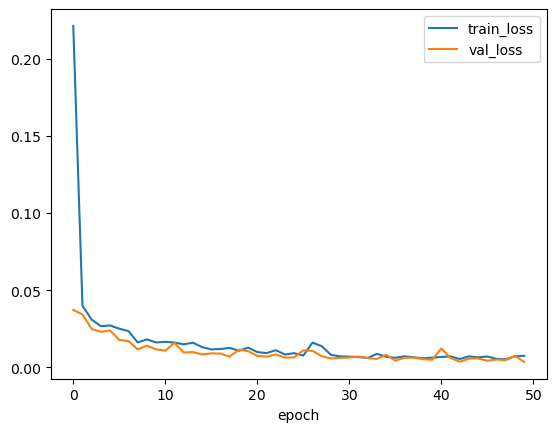

In [15]:
# Inspect and plot training history for best trial
display(df_epochs.info())
df_epochs[['train_loss', 'val_loss']].plot(legend=True)
plt.show()

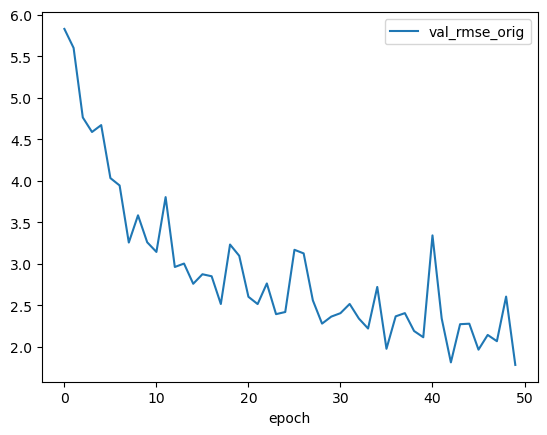

Best RMSE:  1.7798393419177838


In [16]:
df_epochs.val_rmse_orig.plot(legend=True)
plt.show()
print("Best RMSE: ", df_epochs.val_rmse_orig.min())